STORM Hyperparameter Tuner
Enter k (Learning Rate Scale) [default 0.01]: 1
Enter w (Adaptive Denom Weight) [default 0.1]: 0.5
Enter c (Momentum Scale) [default 1.0]: 50

Running with: k=1.0, w=0.5, c=50.0


--- SGD (lr=0.07) ---
Epoch 1: Loss 1.16174
Epoch 2: Loss 0.60619
Epoch 3: Loss 0.52354
Epoch 4: Loss 0.45456
Epoch 5: Loss 0.41237
Epoch 6: Loss 0.36956
Epoch 7: Loss 0.33533
Epoch 8: Loss 0.30376
Epoch 9: Loss 0.29125
Epoch 10: Loss 0.26960
Epoch 11: Loss 0.22496
Epoch 12: Loss 0.20358
Epoch 13: Loss 0.18319
Epoch 14: Loss 0.15352
Epoch 15: Loss 0.15660
Time: 71.55s

--- Adam (lr=0.007) ---
Epoch 1: Loss 0.86860
Epoch 2: Loss 0.48064
Epoch 3: Loss 0.41241
Epoch 4: Loss 0.36945
Epoch 5: Loss 0.33202
Epoch 6: Loss 0.30311
Epoch 7: Loss 0.27219
Epoch 8: Loss 0.25173
Epoch 9: Loss 0.23530
Epoch 10: Loss 0.20933
Epoch 11: Loss 0.17355
Epoch 12: Loss 0.14720
Epoch 13: Loss 0.13320
Epoch 14: Loss 0.10247
Epoch 15: Loss 0.09885
Time: 74.59s

--- STORM (k=1.0, w=0.5, c=50.0) ---
Epoch 1: L

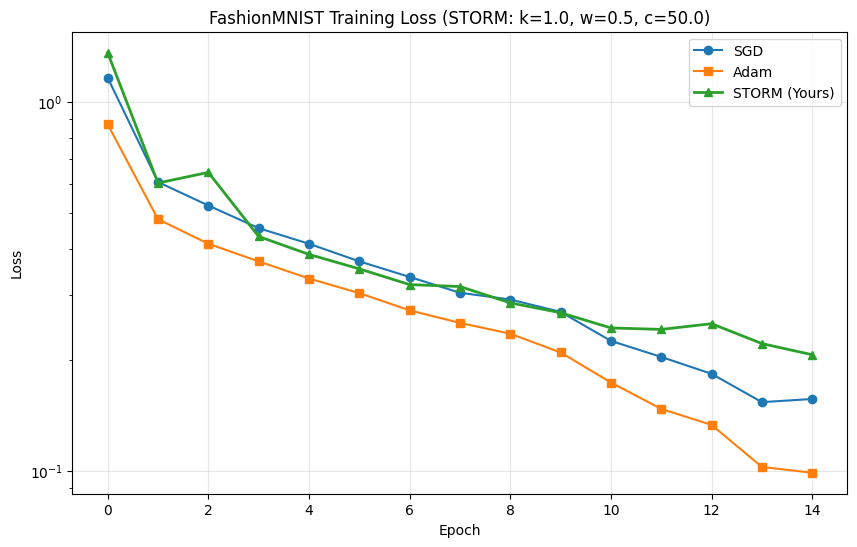

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

class Storm(optim.Optimizer):
    def __init__(self, params, k=0.01, w=0.1, c=1.0):
        if k < 0.0: raise ValueError(f"Invalid k: {k}")
        if w < 0.0: raise ValueError(f"Invalid w: {w}")
        if c < 0.0: raise ValueError(f"Invalid c: {c}")
        defaults = dict(k=k, w=w, c=c)
        super(Storm, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure):
        if closure is None: raise RuntimeError("STORM requires a closure.")

        # 1. COMPUTE GRADIENTS AT CURRENT STATE (x_t)
        # We must call closure first to ensure p.grad is fresh for x_t
        with torch.enable_grad():
            loss = closure()

        # Initialization
        # Check if first param has state. If not, initialize.
        if len(self.state[self.param_groups[0]['params'][0]]) == 0:
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None: continue
                    grad = p.grad
                    state = self.state[p]

                    state['step'] = 1
                    state['momentum_buffer'] = grad.clone()
                    state['grad_sq_sum'] = grad.norm().pow(2).item()
                    state['params_prev'] = p.clone() # Store x_1

                    # Initial Update (Standard SGD)
                    denom = (group['w'] + state['grad_sq_sum']) ** (1/3)
                    lr = group['k'] / denom
                    p.add_(grad, alpha=-lr)
            return loss

        # STORM Loop (t > 1)

        # 2. Snapshot Current State (x_t) and Gradients
        saved_grads = []
        saved_params = []

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    saved_grads.append(None)
                    saved_params.append(None)
                    continue
                saved_grads.append(p.grad.clone())
                saved_params.append(p.clone())

                # Load x_{t-1} into model
                p.copy_(self.state[p]['params_prev'])

        # 3. Compute nabla f(x_{t-1}) using CURRENT batch
        # This overwrites p.grad with gradients at the old position
        self.zero_grad()
        with torch.enable_grad():
            _ = closure() # Loss is same, we just need the grads

        # 4. Compute Updates
        idx = 0
        for group in self.param_groups:
            k, w, c = group['k'], group['w'], group['c']

            for p in group['params']:
                if p.grad is None:
                    idx += 1
                    continue

                state = self.state[p]
                state['step'] += 1

                # Gradients
                grad_prev_point = p.grad        # \nabla f(x_{t-1})
                grad_curr_point = saved_grads[idx] # \nabla f(x_t)
                x_current = saved_params[idx]      # x_t
                d_prev = state['momentum_buffer']  # d_{t-1}

                # Restore Model to x_t (Crucial before update!)
                p.copy_(x_current)

                # Adaptive Learning Rate
                curr_grad_norm_sq = grad_curr_point.norm().pow(2).item()
                state['grad_sq_sum'] += curr_grad_norm_sq

                denom = (w + state['grad_sq_sum']) ** (1/3)
                eta_t = k / denom

                # Adaptive Momentum Weight (a_t)
                a_t = c * (eta_t ** 2)
                a_t = min(a_t, 1.0)

                # STORM Estimator Update
                # d_t = nabla f(x_t) + (1 - a)(d_{t-1} - nabla f(x_{t-1}))
                term = d_prev.sub(grad_prev_point)
                d_t = grad_curr_point.add(term, alpha=(1.0 - a_t))

                # Update State
                state['momentum_buffer'] = d_t.clone()
                state['params_prev'] = x_current.clone() # Save x_t for next step

                # Apply Weight Update
                p.add_(d_t, alpha=-eta_t)

                idx += 1

        return loss

# ==========================================
# 2. Benchmark Setup
# ==========================================

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # REMOVED DROPOUT for Variance Reduction stability
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def get_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    try:
        train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)
    except:
        print("Using existing data...")
        train_dataset = datasets.FashionMNIST('./data', train=True, download=False, transform=transform)
        test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

    train_subset = torch.utils.data.Subset(train_dataset, range(5000))
    test_subset = torch.utils.data.Subset(test_dataset, range(1000))

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=1000)
    return train_loader, test_loader

def run_experiment(name, opt_func, epochs=10):
    print(f"\n--- {name} ---")
    torch.manual_seed(42)
    device = torch.device("cpu")

    model = SimpleCNN().to(device)
    train_loader, test_loader = get_data()
    optimizer = opt_func(model.parameters())

    losses = []

    start = time.time()
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        count = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                return loss

            # The fixed step() now calls closure() internally immediately
            loss = optimizer.step(closure)
            epoch_loss += loss.item()
            count += 1

        avg_loss = epoch_loss / count
        losses.append(avg_loss)
        print(f"Epoch {epoch}: Loss {avg_loss:.5f}")

    print(f"Time: {time.time()-start:.2f}s")
    return losses

if __name__ == "__main__":
    epochs = 15

    # --- INPUT CELL FOR TUNING ---
    print("="*40)
    print("STORM Hyperparameter Tuner")
    print("="*40)

    # Get K
    in_k = input("Enter k (Learning Rate Scale) [default 0.01]: ")
    k_val = float(in_k) if in_k.strip() else 0.01

    # Get W
    in_w = input("Enter w (Adaptive Denom Weight) [default 0.1]: ")
    w_val = float(in_w) if in_w.strip() else 0.1

    # Get C
    in_c = input("Enter c (Momentum Scale) [default 1.0]: ")
    c_val = float(in_c) if in_c.strip() else 1.0

    print(f"\nRunning with: k={k_val}, w={w_val}, c={c_val}\n")
    # -----------------------------

    # 1. SGD (Baseline)
    sgd_losses = run_experiment('SGD (lr=0.07)',
        lambda p: optim.SGD(p, lr=0.01, momentum=0.9), epochs)

    # 2. Adam (Competitor)
    adam_losses = run_experiment('Adam (lr=0.007)',
        lambda p: optim.Adam(p, lr=0.001), epochs)

    # 3. STORM (User Inputs)
    storm_name = f'STORM (k={k_val}, w={w_val}, c={c_val})'
    storm_losses = run_experiment(storm_name,
        lambda p: Storm(p, k=k_val, w=w_val, c=c_val), epochs)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(sgd_losses, label='SGD', marker='o')
    plt.plot(adam_losses, label='Adam', marker='s')
    plt.plot(storm_losses, label='STORM (Yours)', marker='^', linewidth=2)
    plt.title(f'FashionMNIST Training Loss (STORM: k={k_val}, w={w_val}, c={c_val})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [22]:
import itertools

# --- Grid Search Configuration ---
# We define a search space based on observations:
# k: Needs to be high enough to learn, but low enough not to explode.
# w: Controls stability. Higher values (1.0) dampen early explosions.
# c: Momentum scale. Paper uses high values, but 1-10 is safer for small CNNs.

grid_k = [1, 2, 3, 5, 7, 10]
grid_w = [0.1, 0.5, 1.0]
grid_c = [1.0, 10.0, 50, 100]

param_grid = list(itertools.product(grid_k, grid_w, grid_c))
print(f"Starting Grid Search over {len(param_grid)} combinations...")
print(f"Grid: k={grid_k}, w={grid_w}, c={grid_c}")
print("-" * 60)

best_loss = float('inf')
best_params = None
results = []

# Using 5 epochs for the search to be quick
search_epochs = 5

for (k, w, c) in param_grid:
    print(f"Testing combo: k={k}, w={w}, c={c} ... ", end="")

    # 1. Reset Model & Optimizer
    torch.manual_seed(42) # Ensure identical initialization for fair comparison
    model = SimpleCNN().to(torch.device("cpu"))
    train_loader, _ = get_data() # Reuse get_data from previous cell

    optimizer = Storm(model.parameters(), k=k, w=w, c=c)

    # 2. Train for 'search_epochs'
    final_loss = 0.0
    nan_detected = False

    for epoch in range(search_epochs):
        model.train()
        epoch_loss = 0
        count = 0

        for data, target in train_loader:
            if nan_detected: break

            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            # Check for divergence
            if torch.isnan(loss) or loss.item() > 1e6:
                nan_detected = True
                break

            epoch_loss += loss.item()
            count += 1

        if nan_detected: break
        final_loss = epoch_loss / count

    # 3. Record Results
    if nan_detected:
        print("FAILED (Exploded/NaN)")
        results.append(((k, w, c), float('inf')))
    else:
        print(f"Final Loss: {final_loss:.5f}")
        results.append(((k, w, c), final_loss))

        if final_loss < best_loss:
            best_loss = final_loss
            best_params = (k, w, c)

print("-" * 60)
print(f"BEST RESULT: k={best_params[0]}, w={best_params[1]}, c={best_params[2]}")
print(f"Lowest Training Loss: {best_loss:.5f}")
print("-" * 60)

# --- Visualize the Best Run vs Baselines (Full 10 Epochs) ---
print("\nVerifying Best Combo for full 10 epochs...")
best_k, best_w, best_c = best_params

# Run Best STORM
storm_losses = run_experiment(f'STORM (Best: k={best_k})',
                              lambda p: Storm(p, k=best_k, w=best_w, c=best_c),
                              epochs=10)

# Run Baselines again for context
sgd_losses = run_experiment('SGD', lambda p: optim.SGD(p, lr=0.01, momentum=0.9), epochs=10)
adam_losses = run_experiment('Adam', lambda p: optim.Adam(p, lr=0.001), epochs=10)

# Plot
plt.figure(figsize=(12, 7))
plt.plot(sgd_losses, label='SGD (0.01)', linestyle='--', alpha=0.6)
plt.plot(adam_losses, label='Adam (0.001)', linestyle='--', alpha=0.6)
plt.plot(storm_losses, label=f'STORM (k={best_k}, w={best_w}, c={best_c})',
         linewidth=2.5, marker='o')

plt.title("Grid Search Winner vs Baselines")
plt.xlabel("Epochs")
plt.ylabel("Training Loss (Log Scale)")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Starting Grid Search over 72 combinations...
Grid: k=[1, 2, 3, 5, 7, 10], w=[0.1, 0.5, 1.0], c=[1.0, 10.0, 50, 100]
------------------------------------------------------------
Testing combo: k=1, w=0.1, c=1.0 ... FAILED (Exploded/NaN)
Testing combo: k=1, w=0.1, c=10.0 ... FAILED (Exploded/NaN)
Testing combo: k=1, w=0.1, c=50 ... Final Loss: 0.44155
Testing combo: k=1, w=0.1, c=100 ... Final Loss: 0.44364
Testing combo: k=1, w=0.5, c=1.0 ... FAILED (Exploded/NaN)
Testing combo: k=1, w=0.5, c=10.0 ... Final Loss: 0.61970
Testing combo: k=1, w=0.5, c=50 ... Final Loss: 0.38592
Testing combo: k=1, w=0.5, c=100 ... Final Loss: 0.39193
Testing combo: k=1, w=1.0, c=1.0 ... Final Loss: 5.29946
Testing combo: k=1, w=1.0, c=10.0 ... Final Loss: 0.65639
Testing combo: k=1, w=1.0, c=50 ... Final Loss: 0.47993
Testing combo: k=1, w=1.0, c=100 ... Final Loss: 0.43511
Testing combo: k=2, w=0.1, c=1.0 ... FAILED (Exploded/NaN)
Testing combo: k=2, w=0.1, c=10.0 ... Final Loss: 0.41463
Testing combo: k

KeyboardInterrupt: 